In [78]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import statistics
import seaborn as sns

In [79]:
main = pd.read_csv("C:\\soft computing\\E0.csv")
df = pd.read_csv("C:\\soft computing\\final.csv")

In [80]:
main.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,1.84,0.75,2.01,1.89,2.02,1.91,2.13,1.92,2.02,1.87
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1.70,0.25,1.78,2.13,1.79,2.17,1.85,2.18,1.79,2.12
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,2.62,-1.50,1.85,2.05,1.85,2.08,1.90,2.16,1.84,2.04
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,1.92,-0.50,2.03,1.87,2.04,1.88,2.09,1.91,2.02,1.86
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,1.73,0.25,1.92,1.98,1.93,1.99,1.95,2.01,1.91,1.97


In [81]:
df.head()

,Unnamed: 0,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
0,30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16
1,31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2
2,32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3
3,33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3
4,34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3


Total number of matches: 48
Number of features: 105
Number of matches won by home team: 17
Home team win rate: 35.42%
Home team not win rate: 64.58%


<AxesSubplot:xlabel='FTR', ylabel='count'>

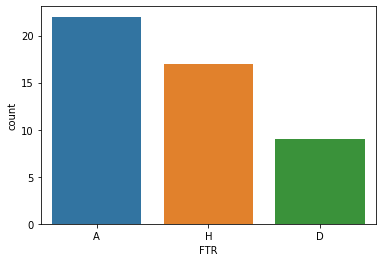

In [82]:
n_matches = main.shape[0]
n_features = main.shape[1] - 1
n_homewins = len(main[main.FTR == 'H'])
win_rate = (float(n_homewins) / (n_matches)) * 100

print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Home team win rate: {:.2f}%".format(win_rate))
print("Home team not win rate: {:.2f}%".format(100-win_rate))



sns.countplot(x="FTR", data=main)

<AxesSubplot:xlabel='Date', ylabel='count'>

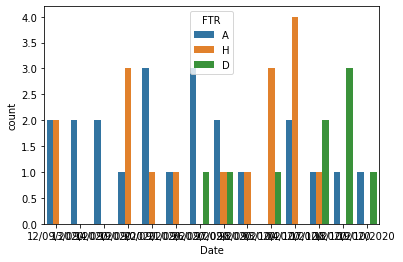

In [83]:
sns.countplot(x="Date", hue="FTR", data=main)

In [84]:
df.describe()

,Unnamed: 0,HTP,ATP,HTGD,ATGD,DiffFormPts,DiffLP
count,5.000000,5.000000,5.00000,5.00000,5.000000,5.000000,5.000000
mean,32.000000,0.950000,0.85000,-0.05000,0.050000,0.100000,-3.000000
std,1.581139,0.209165,0.48734,0.37081,0.570088,0.379144,7.778175
min,30.000000,0.750000,0.25000,-0.50000,-0.750000,-0.500000,-16.000000
25%,31.000000,0.750000,0.50000,-0.25000,-0.250000,0.000000,-3.000000
50%,32.000000,1.000000,1.00000,0.00000,0.250000,0.250000,-2.000000
75%,33.000000,1.000000,1.00000,0.00000,0.250000,0.250000,3.000000
max,34.000000,1.250000,1.50000,0.50000,0.750000,0.500000,3.000000


In [85]:
X_all = df.drop(['FTR'],axis=1)
y_all = df['FTR']

In [86]:
from sklearn.preprocessing import scale
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])


In [87]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    output = pd.DataFrame(index = X.index)

    for col, col_data in X.iteritems():

        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (18 total features):
['Unnamed: 0', 'HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM2_D', 'HM2_L', 'HM3_W', 'AM1_D', 'AM1_W', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [88]:
print ("\nFeature values:")
display(X_all.head())


Feature values:


,Unnamed: 0,HTP,ATP,HM1_D,HM1_L,HM2_D,HM2_L,HM3_W,AM1_D,AM1_W,AM2_L,AM2_W,AM3_D,AM3_L,HTGD,ATGD,DiffFormPts,DiffLP
0,30,1.603567,0.344124,1,0,1,0,1,1,0,0,1,0,1,1.658312,0.392232,0.25,-1.868619
1,31,-1.069045,-1.376494,0,1,0,1,1,1,0,1,0,0,1,-1.356801,-1.568929,0.50,0.143740
2,32,0.267261,0.344124,0,1,1,0,1,1,0,0,1,0,1,0.150756,0.392232,0.00,0.000000
3,33,-1.069045,-0.802955,0,1,0,1,1,1,0,1,0,1,0,-0.603023,-0.588348,0.25,0.862439
4,34,0.267261,1.491202,1,0,0,1,1,0,1,0,1,0,1,0.150756,1.372813,-0.50,0.862439


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=2)

In [99]:
from time import time 
y_preds = []
def train_classifier(clf, X_train, y_train):
 
 # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
def predict_labels(clf, features, target): 
    
    start = time()
    y_pred = clf.predict(features)
    y_preds.append(y_pred)
    end = time()
 
 # Print and return results
    
    return sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    train_classifier(clf, X_train, y_train)
    
    acc = predict_labels(clf, X_train, y_train)
    print("Accuracy score for training set: ", acc*100, "%")
    
    acc = predict_labels(clf, X_test, y_test)
    print("Accuracy score for test set: ",acc*100, "%")


In [105]:
clf_A = LogisticRegression(random_state = 42)
clf_B = MLPClassifier(max_iter= 750,activation='relu',hidden_layer_sizes= 1000) 
clf_C = SVC(random_state = 912, kernel='rbf')
clf_D = xgb.XGBClassifier(seed = 82)
train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print('')

Training a LogisticRegression using a training set size of 2. . .
Accuracy score for training set:  100.0 %
Accuracy score for test set:  66.66666666666666 %

Training a MLPClassifier using a training set size of 2. . .
Accuracy score for training set:  100.0 %
Accuracy score for test set:  66.66666666666666 %

Training a SVC using a training set size of 2. . .
Accuracy score for training set:  100.0 %
Accuracy score for test set:  66.66666666666666 %

Training a XGBClassifier using a training set size of 2. . .
[14:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score for training set:  50.0 %
Accuracy score for test set:  33.33333333333333 %



C:\Users\RamyaSeenu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [102]:
print(y_test)
print(y_preds[1])
predss = y_preds[1]

2     H
4    NH
1    NH
Name: FTR, dtype: object
['NH' 'NH' 'NH']


In [103]:
mod_c.predict(X_test)

array(['NH', 'NH', 'NH'], dtype=object)

In [104]:
print('ACTUAL OUTPUT')
print(' ') 
for i in y_test:
    if i == 'H': 
        print('Home WIN')
    elif i == 'NH': 
        print('Away Team win') 
    else:
        print('Draw')
print(' ') 
print('PREDICTED OUTPUT')
print(' ') 
for i in predss:
    if i == 'H': 
        print('Home WIN')
    elif i == 'NH': 
        print('Away Team win') 
    else:
        print('Draw')


ACTUAL OUTPUT
 
Home WIN
Away Team win
Away Team win
 
PREDICTED OUTPUT
 
Away Team win
Away Team win
Away Team win
